# Image Offsets: Process sequence

This notebook transforms the procedures developed in `Offsets_1.ipynb` into callable functions. 

These functions are used in a loop to process an entire sequence of images. Results are later examined in plots.

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table, vstack
from astropy.stats import SigmaClip

import photutils
from photutils import Background2D, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy

Populating the interactive namespace from numpy and matplotlib


## Initialization

Define values to be used in the processing functions, and throughout the script.

In [2]:
dirpath = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/'
file_list = glob.glob(dirpath + '/*.ARW')

In [3]:
# parameters for background subtraction and star finding
bkg_sigma = 3.0
bkg_cell_footprint = (100, 100)
bkg_filter = (5, 5)
dao_fwhm = 3.5
dao_threshold = 10.

# operators
sigma_clip = SigmaClip(sigma=bkg_sigma)
bkg_estimator = ModeEstimatorBackground()

In [4]:
# 1st test image - this will be the reference image which subsequent images
# will have their offsets computed against. We need to read it here to get 
# the camera color array specification as well.
fname = file_list[0]
raw = rawpy.imread(fname)
ref_imarray = raw.raw_image_visible.astype(float)

In [5]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

In [6]:
# normalization factors for the RGB arrays
red_norm = 1.321875  # smooth background
green_norm = 1.
blue_norm = 1.27695312

## Processing functions

In [7]:
# computes position offsets between two tables. 
def get_offsets(sources, sources_prev):

    sources.add_column(np.nan, name='xoffset')
    sources.add_column(np.nan, name='yoffset')
    sources.add_column(0, name='ref_row')
    sources.add_column(0, name='prev_row')

    # loop over rows in previous table
    for row_index_prev in range(len(sources_prev)):
        # index in reference table
        ref_row = sources_prev[row_index_prev]['ref_row']

        # if previous table does not contain a pointer to the reference 
        # table, ignore.
        if ref_row == 0:
            continue

        # get position in previous table
        x_prev = sources_prev[row_index_prev]['xcentroid']
        y_prev = sources_prev[row_index_prev]['ycentroid']

        # loop over rows in current table
        for row_index in range(len(sources)):
            x = sources[row_index]['xcentroid']
            y = sources[row_index]['ycentroid']

            # offsets in relation to previous table - these are the ones to check for proximity
            x_off_previous = x - x_prev
            y_off_previous = y - y_prev

            # check for proximity, and store relevant info if found
            if abs(x_off_previous) <= 4. and abs(y_off_previous) <= 4.:

                # offsets in relation to reference table
                sources[row_index]['xoffset'] = x - sources_ref[ref_row]['xcentroid']
                sources[row_index]['yoffset'] = y - sources_ref[ref_row]['ycentroid']

                # store pointers to rows in reference and previous tables
                sources[row_index]['ref_row'] = ref_row
                sources[row_index]['prev_row'] = row_index_prev
                
                #TODO 
                # instead of breaking, do an estimate of where the centroid would be,
                # given the current position, and the offsets from the previous table.
                # In other words, repeat the offset from the previous table. See if this
                # will cause the finding algorithm to pick up in the next image.

                break # if there is another star that matches the criterion, just ignore it
                
    return sources

In [8]:
# creates a table with star positions, given a path to an image file
def find_stars(path):

    with rawpy.imread(path) as raw:
        imarray = raw.raw_image_visible.astype(float)

        # normalize
        raw_norm_1 = imarray * (red_mask * red_norm)
        raw_norm_2 = raw_norm_1 + imarray * (green_mask * 1.0)
        raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)

        # handle saturated pixels
        raw_norm = np.where(imarray > 16380, imarray, raw_norm)

        # compute and subtract background
        bkg = Background2D(raw_norm, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        subtracted = raw_norm - bkg.background

        # find stars
        daofind = DAOStarFinder(fwhm=dao_fwhm, threshold=dao_threshold * bkg.background_rms_median) 
        sources = daofind(subtracted)

        return sources, subtracted

In [9]:
# keep only the NaN-free entries
def clean_nans(sources):
    has_nan = np.zeros(len(sources), dtype=bool)
    xoff = np.array(sources['xoffset'])
    has_nan |= np.isnan(xoff)
    return sources[~has_nan]

## Process sequence

In [10]:
# find stars in reference image
files = sort(file_list)
sources_ref, subtracted_ref = find_stars(files[0])

# positions storage
positions_tables = []
positions_tables.append(sources_ref)

# array for stacking subtracted images
image_stack = np.zeros_like(subtracted_ref)

# add default offset columns to reference table
sources_ref.add_column(0., name='xoffset')
sources_ref.add_column(0., name='yoffset')

# in ref table, rows point to themselves
sources_ref.add_column(sources_ref['id']-1, name='ref_row')
sources_ref.add_column(sources_ref['id']-1, name='prev_row')

# force reference image to be the "previous" image
sources_prev = sources_ref

sources_ref

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xoffset,yoffset,ref_row,prev_row
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64
1,2176.847992578662,3.485725442414608,0.6380276660334187,0.2967138087588021,0.47330240992537725,25,0.0,1618.2148227409034,1.819205528140097,-0.6497044176625398,0.0,0.0,0,0
2,1990.0865623261914,11.289815410206222,0.7816068315325836,0.440295424573588,0.1727197387782676,25,0.0,2277.884806931481,2.184413230038624,-0.8483369955095359,0.0,0.0,1,1
3,2419.213954212598,14.97430298023786,0.352729627254312,0.03816353071695001,0.2658131112748434,25,0.0,3477.3208114196086,5.492234707340444,-1.8493727206856385,0.0,0.0,2,2
4,1664.3816651871216,17.202897274148917,0.778092304505935,0.5636436161976615,-0.0231913073112475,25,0.0,1992.8272214612055,1.870500920267671,-0.6798948155070018,0.0,0.0,3,3
5,2084.468356817954,25.02882949157111,0.6879526244711576,0.21304079754236874,0.09174489469635545,25,0.0,12543.013528388119,12.608558539709907,-2.751663597869471,0.0,0.0,4,4
6,4093.8650408050307,25.00559691427592,0.5804118219266327,-0.39381309514377116,-0.35531452117283935,25,0.0,902.2527492978448,1.1762333569351162,-0.17623372861776931,0.0,0.0,5,5
7,63.30875345971053,28.872981444597755,0.34990126049893994,-0.47686828459277003,-0.3599182508624009,25,0.0,3311.5511686247974,4.432731773534378,-1.6166786318811717,0.0,0.0,6,6
8,2530.9062781067846,29.85781406641512,0.6975354842949936,-0.8394848997840695,0.04917873637899748,25,0.0,1307.0572468825503,1.3038703644821146,-0.2880860360266436,0.0,0.0,7,7
9,3261.1653100147605,30.302496044191695,0.7529154891326023,-0.34481138731886396,-0.05058786909308034,25,0.0,3733.6968659634304,3.489397787688952,-1.3568762034646797,0.0,0.0,8,8


In [11]:
# loop over list of remaining images
for file_path in files[1:]:
    
    # find stars
    sources, subtracted = find_stars(file_path)
    
    # compute offsets
    sources_current = get_offsets(sources, sources_prev)
    
    sources_current_no_nan = clean_nans(sources_current)
    
    positions_tables.append(sources_current_no_nan)
    
    # save table to file
    
    # for next iteration, current table becomes previous
    sources_prev = sources_current_no_nan
    
    # update image stack
    image_stack += subtracted
    
    print(file_path, len(sources_current_no_nan))

../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.ARW 2624
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.ARW 2275
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03773.ARW 2046
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03774.ARW 1867
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03775.ARW 1715
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03776.ARW 1601
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03777.ARW 1503
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03778.ARW 1430
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW 1353
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03780.ARW 1301
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03781.ARW 1226
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03782.ARW 1171
../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03783.ARW 1124
../astrophotography_data/MilkyWayPrettyBoy/12800/li

In [12]:
sources_current_no_nan

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xoffset,yoffset,ref_row,prev_row
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64
24,2764.9572703416884,69.47866028179592,0.58446416868675,-0.36314326430018706,0.17199265825078847,25,0.0,3583.3926309957947,4.317840773179466,-1.588166557591325,-51.122224748603,-2.067335592883097,23,0
72,2490.09523420419,213.00960029088893,0.7457697226009773,-0.3407427083188085,0.07041524752571499,25,0.0,2836.2176000092445,2.919389097883871,-1.1632299546696798,-46.600612294858365,-0.3515501109380068,67,1
115,2607.9351563575406,310.9898934431524,0.8211473771800106,-0.22549019467619194,0.11674841365503114,25,0.0,7324.907782707675,7.008737368576392,-2.1140994660114227,-45.50698555669578,-2.326174228411162,113,2
123,2285.418054237603,327.6962574181284,0.6846552713504211,-0.3801013913326161,0.05330050758008461,25,0.0,1525.0410211168064,1.570368165423631,-0.4900037066082076,-43.7036266694804,1.2698507157375616,118,3
150,2232.5106793769023,365.96451989570784,0.34748797002359966,-0.5759101121650455,-0.18755224970089074,25,0.0,915.6814899859245,1.5404879451156255,-0.4691457603807788,-42.66725031457918,1.70954158681252,143,4
152,2789.596987179438,368.62158967855277,0.7449569686633452,0.11029475267058476,0.05100697876263963,25,0.0,7098.722666733794,6.746352319479127,-2.0726725447753362,-45.808541223507746,-4.745576870100763,152,5
156,2446.7392666903497,373.4795112294399,0.4634201123956109,-0.29644710168086585,0.11040166663029843,25,0.0,1876.618472459002,2.7199239056065236,-1.0863918852348866,-43.49949392954841,-0.6460591974469025,153,6
162,2152.69208056611,377.4564474458978,0.575174485678643,-0.15768016531214157,0.2165525837908815,25,0.0,4688.426456486052,5.918738648516035,-1.9305729085488046,-42.624683573388666,2.735255640146022,154,7
165,2197.8764509491175,380.63639607886665,0.8393302476153313,0.6175629841929956,0.28040384399439405,25,0.0,1713.847478152245,1.5564283587863237,-0.48032283808467735,-42.64437026384212,2.449380476660963,156,8


In [13]:
# positions = [(x,y) for x,y in zip(sources_current_no_nan['xcentroid'], sources_current_no_nan['ycentroid'])]
# positions_ref = [(x,y) for x,y in zip(sources_ref['xcentroid'], sources_ref['ycentroid'])]

# apertures = CircularAperture(positions, r=5.)
# apertures_ref = CircularAperture(positions_ref, r=5.)

# plt.figure(figsize=[9, 6])
# plt.imshow(image_stack, vmin=-10, vmax=10000, cmap='binary')
# plt.colorbar()
# _ = apertures.plot(color='red')
# _ = apertures_ref.plot(color='yellow')

<IPython.core.display.Javascript object>


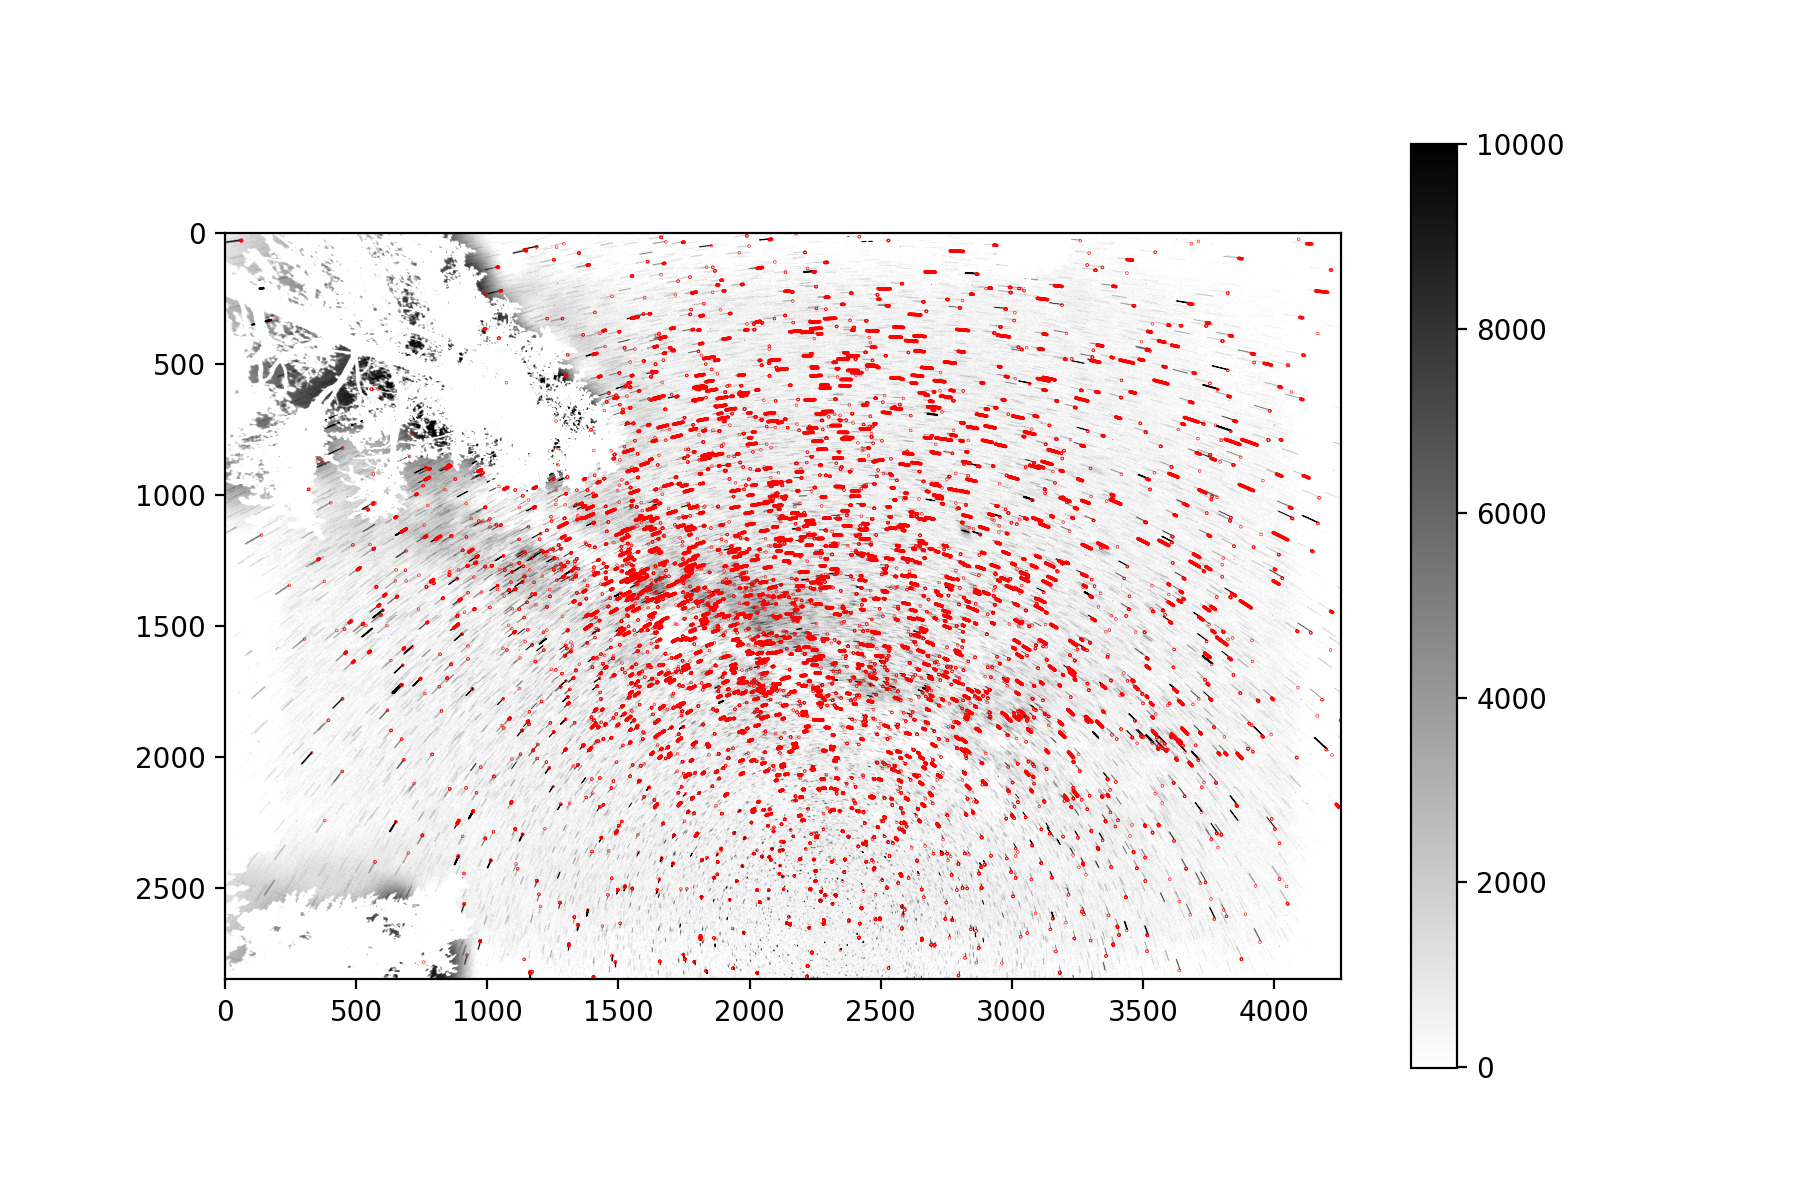

In [14]:
plt.figure(figsize=[9, 6])
plt.imshow(image_stack, vmin=-10, vmax=10000, cmap='binary')
plt.colorbar()

for positions_t in positions_tables:
    positions = [(x,y) for x,y in zip(positions_t['xcentroid'], positions_t['ycentroid'])]
    apertures = CircularAperture(positions, r=1.)
    _ = apertures.plot(color='red')